### Importing Packages

In [1]:
# basic packages
import copy
import time
import math
import random
import warnings

# standard packages
import pylab as pl
import numpy as np
import pandas as pd
import seaborn as sns

# matplotlib package
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import matplotlib.colors as mcolors

# scipy package
from scipy.spatial import distance
from scipy.stats import norm,skew,kurtosis,kurtosistest

# keras package
from keras.utils import np_utils
from keras.models import Sequential
from keras import initializers as init
from keras.layers import Activation,Dense,Dropout
from keras.wrappers.scikit_learn import KerasClassifier

# sklearn package
from sklearn.cluster import KMeans
from sklearn import tree,random_projection
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA,FastICA
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,KFold
from sklearn.metrics import make_scorer,accuracy_score,f1_score,silhouette_score,confusion_matrix

Using TensorFlow backend.


### User Defined Functions

##### Clustering Algorithms

In [2]:
# K-means Clusters
def kmeans_function(data,k_min,k_max):
    sse,ss={},{}
    for k in range(k_min,1+k_max):
        kmeans = KMeans(n_clusters=k,random_state=0).fit(data)
        sse[k] = kmeans.inertia_
        ss[k]  = silhouette_score(data,kmeans.labels_,sample_size=20000,random_state=10)
        
    plt.figure()
    plt.plot(list(sse.keys()),list(sse.values()))
    plt.xlabel('Number of Clusters')
    plt.ylabel('SSE')
    plt.title('SSE vs. Clusters')
    plt.show()
    
    plt.figure()
    plt.plot(list(ss.keys()),list(ss.values()))
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. Clusters')
    plt.show()
    
# Expectation Maximization
def exp_max(data,n_min,n_max):
    n_components = np.arange(n_min,1+n_max)
    models = [GaussianMixture(n,covariance_type='full',random_state=0).fit(data) for n in n_components]
    plt.plot(n_components,[m.bic(data) for m in models],label='BIC')
    plt.plot(n_components,[m.aic(data) for m in models],label='AIC')
    plt.legend(loc='best')
    plt.xlabel('Clusters')
    plt.ylabel('AIC/BIC')
    plt.xticks(np.arange(n_min,1+n_max))
    plt.show()
    
# Clustering Plots
def cluster_plots(X_kmeans,y,split):
    plt.pie(np.unique(X_kmeans,return_counts=True)[1],labels=np.unique(X_kmeans,return_counts=True)[0], 
        autopct='%1.1f%%',shadow=True,startangle=140)
    plt.title('Data distribution in clusters')
    plt.axis('equal')
    plt.show()
    ct=pd.DataFrame(pd.crosstab(X_kmeans,y,normalize='index')*100)
    ct=ct.reset_index()
    ct.columns=['Cluster','0','1']
    p1 = plt.bar(ct['Cluster'],ct['0'],label='0')
    p2 = plt.bar(ct['Cluster'],ct['1'],bottom=ct['0'],label='1')
    plt.axhline(y=split,color='green',linestyle='-')
    plt.xlabel('Clusters')
    plt.ylabel('Count')
    plt.legend(loc='best')
    plt.title('Percentage of output classes across clusters')
    plt.show()

##### Dimensionality Reduction

In [3]:
# Feature Selection using Trees
def features_dt(X,y):
    dt = tree.DecisionTreeClassifier(random_state=108,criterion='entropy')
    dt.fit(X,y)
    print('Number of features before transformation:',X.shape)
    dt.feature_importances_
    model = SelectFromModel(dt,prefit=True)
    X_dt = model.transform(X)
    print('Number of features after transformation:',X_dt.shape)
    print('Columns retained:',X.columns[model.get_support()])
    dt_features = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(dt.feature_importances_)],axis=1)
    dt_features.columns=['feature','imp']
    dt_features.sort_values(by=['imp'],inplace=True)
    dt_features.set_index('feature',inplace=True)
    plt.figure(figsize=(20,3))
    dt_features['imp'].plot.bar(width=0.8)
    plt.title('Variable Importance')
    plt.show()
    return pd.DataFrame(X_dt)

# Principal Components Analysis
def features_pca(X):
    pca = PCA().fit(X)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Variance Explained')
    plt.show()
    pca = PCA(0.90).fit(X)
    X_pca = pca.transform(X)
    print('Number of features with no reduction:',X.shape)
    print('Number of features after PCA:\n',X_pca.shape)
    return pd.DataFrame(X_pca)

# Randomized Projections
def features_rp(X):
    minusOne,one = 0.1,0.9
    rows = len(X)
    m = np.empty((X.shape[1],int(X.shape[1]/2)))
    for i in range(len(m)):
        for j in range(len(m[i])):
            rand = random.random()
            if rand < minusOne: m[i][j] = -1
            elif rand >= one: m[i][j] = 1
            else: m[i][j] = 0
    X_ra = np.mat(X) * m
    print('Number of components after reduction:',X_ra.shape)
    return X_ra

##### Artifical Neural Networks

In [81]:
def split(X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=341107)
    y_train = list(y_train)
    y_test = list(y_test)
    return X_train,y_train,X_test,y_test

def ann_helper(X_train,y_train,in_dims,out_dims,parameters,cv):
    def build_classifier(optimizer,first_hidden_units,second_hidden_units,hidden_activation_fun,output_activation_func):
        classifier = Sequential()
        classifier.add(Dense(output_dim=first_hidden_units,init='uniform',activation=hidden_activation_fun,input_dim=in_dims))
        classifier.add(Dense(output_dim=second_hidden_units,init='uniform',activation=hidden_activation_fun))
        classifier.add(Dense(output_dim=out_dims,init='uniform',activation=output_activation_func))
        classifier.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
        return classifier
    classifier = KerasClassifier(build_fn = build_classifier,verbose=0)
    grid_search = GridSearchCV(estimator=classifier,param_grid=parameters,scoring='accuracy',cv=cv)
    return grid_search

def ann(X_train,y_train,X_test,y_test,in_dims,out_dims,parameters,cv):
    start_time_iter = time.time()
    grid_search=ann_helper(X_train,y_train,X_train.shape[1],out_dims,parameters,cv)
    grid_search = grid_search.fit(X_train,y_train)
    cv_acc=np.round(grid_search.cv_results_['mean_test_score'],4)*100
    train_acc=np.round(accuracy_score(grid_search.predict(X_train),y_train),4)*100
    test_acc=np.round(accuracy_score(grid_search.predict(X_test),y_test),4)*100
    times=time.time()-start_time_iter 
    return grid_search,times,cv_acc,train_acc,test_acc

### Dataset 1 - Appliances Energy Prediction

##### Task 0 - Data Preprocessing

Response classes in dataset1
 0.0    10744
1.0     8991
Name: Heavy_Appliances, dtype: int64


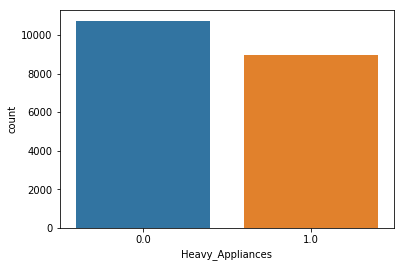

In [5]:
# ignoring warnings
warnings.filterwarnings('ignore')

# importing dataset
data1 = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv')
data1 = data1.iloc[:,1:-2]
data1['Heavy_Appliances'] = np.where(data1.Appliances > data1.Appliances.median(),1,0)

# normalizing the dataset
data1 = (data1-data1.min())/(data1.max()-data1.min())
X_data1,y_data1 = data1.iloc[:,1:-1],data1.iloc[:,-1]
data1 = pd.concat([X_data1,y_data1],axis=1)

# frequency of response classes
print('Response classes in dataset1\n',y_data1.value_counts())
sns.countplot(data1.Heavy_Appliances)
plt.show()

##### Task 1 - Clustering Algorithms

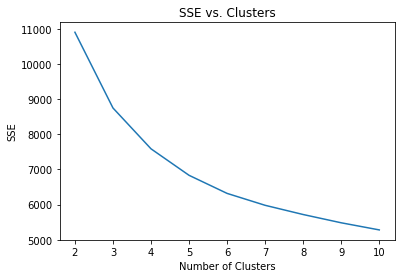

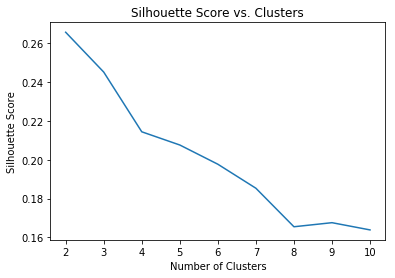

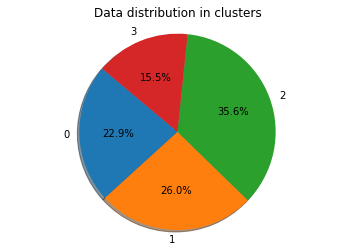

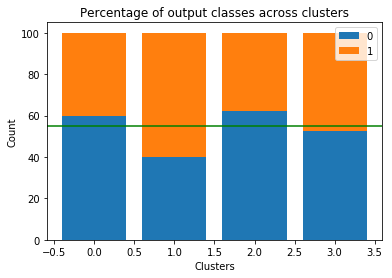

In [38]:
# K-Means
kmeans_function(X_data1,2,10)
cluster_plots(KMeans(n_clusters=4,random_state=0).fit_predict(X_data1),y_data1,55)

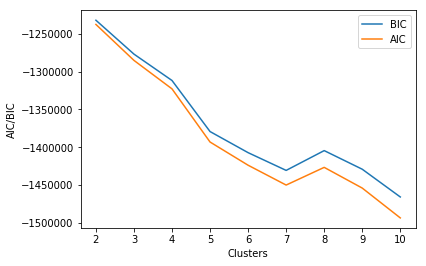

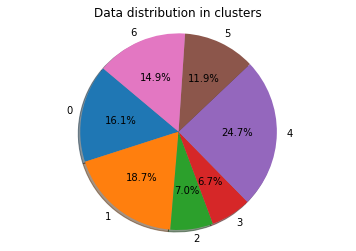

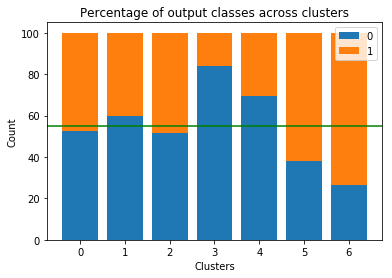

In [39]:
# Expectation Maximization
exp_max(X_data1,2,10)
cluster_plots(GaussianMixture(7,covariance_type='full',random_state=0).fit(X_data1).predict(X_data1),y_data1,55)

##### Task 2 - Dimensionality Reduction

Number of features before transformation: (19735, 25)
Number of features after transformation: (19735, 10)
Columns retained: Index(['lights', 'RH_1', 'T2', 'RH_5', 'RH_6', 'T8', 'RH_8', 'RH_9',
       'Press_mm_hg', 'RH_out'],
      dtype='object')


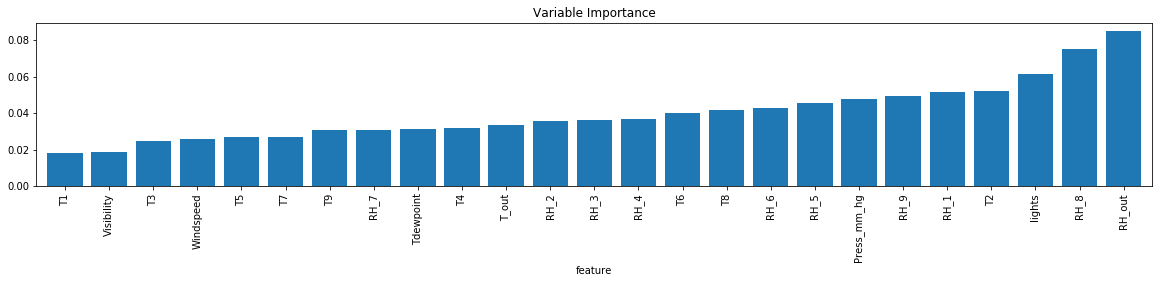

In [40]:
# DT
X_dt1 = features_dt(X_data1,y_data1)

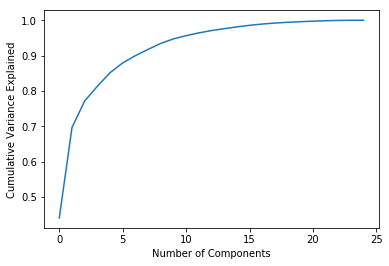

Number of features with no reduction: (19735, 25)
Number of features after PCA:
 (19735, 8)


In [41]:
# PCA
X_pca1 = features_pca(X_data1)

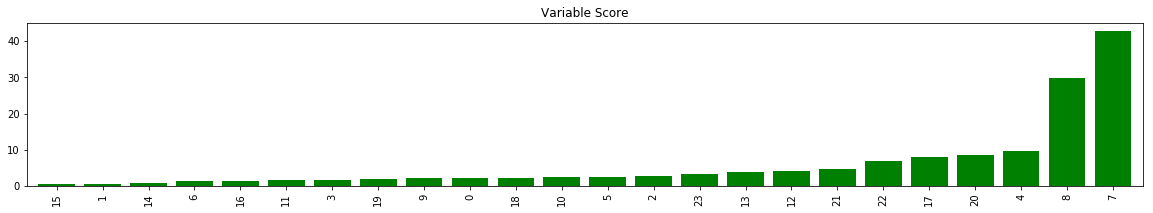

Number of features after ICA (19735, 3)


In [42]:
# ICA
ica = FastICA(random_state=0)
X_ica1 = ica.fit_transform(X_data1)
k,index=[],[]
for i in range(1,X_ica1.shape[1]):
    k.append(abs(kurtosis(X_ica1[:,i],fisher=True)))
    index.append(i)
kdata=pd.DataFrame(k,index)
kdata.reset_index(inplace=True)
kdata.columns=['index','kurtosis']
kdata=kdata.sort_values(['kurtosis'],ascending=[1])
plt.figure(figsize=(20,3))
kdata['kurtosis'].plot.bar(width=0.8,color='green')
plt.title('Variable Score')
plt.show()
X_ica1=X_ica1[:,kdata[kdata['kurtosis']<=1]['index']]
print('Number of features after ICA',X_ica1.shape)

In [43]:
# RP
X_rp1 = features_rp(X_data1)

Number of components after reduction: (19735, 12)


##### Task 3 - Clustering + Reduction

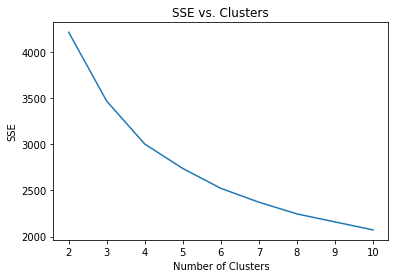

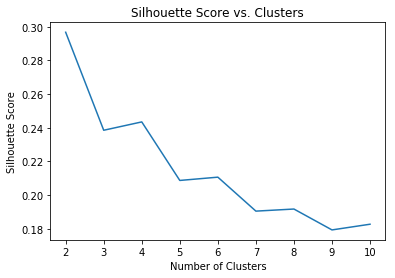

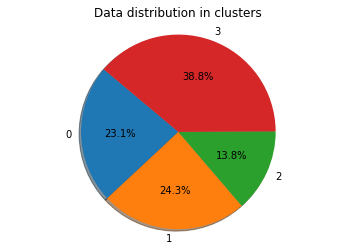

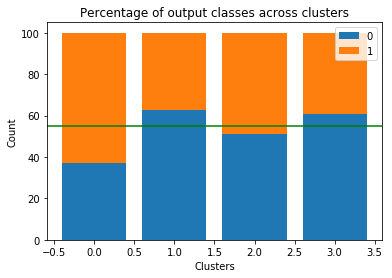

In [67]:
kmeans_function(X_dt1,2,10)
cluster_plots(KMeans(n_clusters=4,random_state=0).fit_predict(X_dt1),y_data1,55)

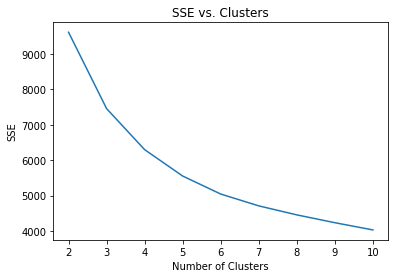

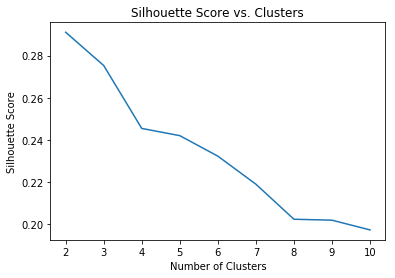

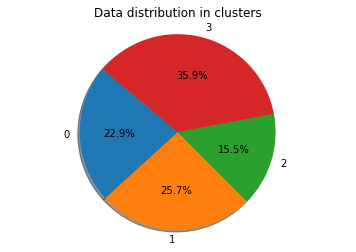

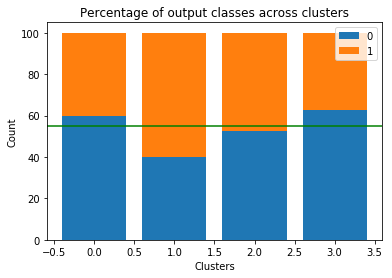

In [45]:
kmeans_function(X_pca1,2,10)
cluster_plots(KMeans(n_clusters=4,random_state=0).fit_predict(X_pca1),y_data1,55)

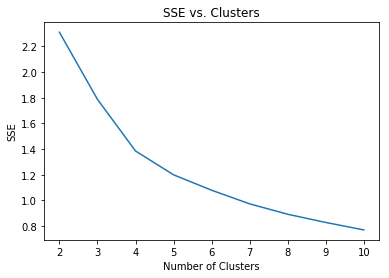

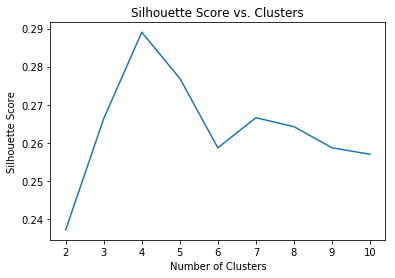

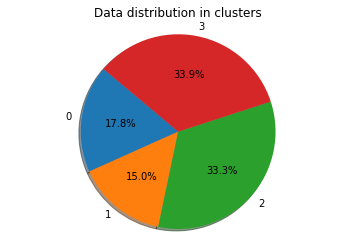

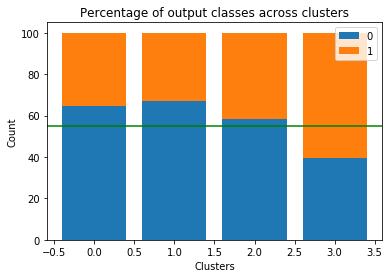

In [46]:
kmeans_function(X_ica1,2,10)
cluster_plots(KMeans(n_clusters=4,random_state=0).fit_predict(X_ica1),y_data1,55)

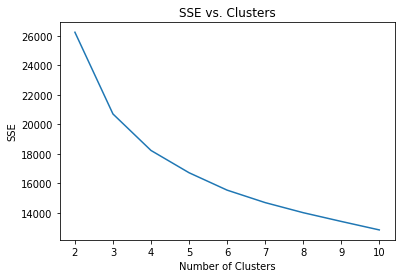

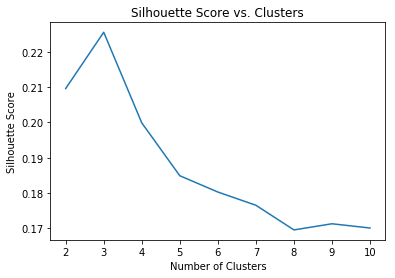

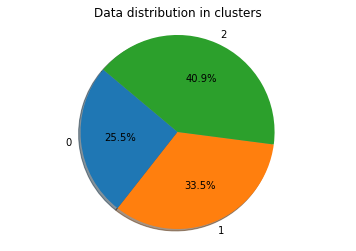

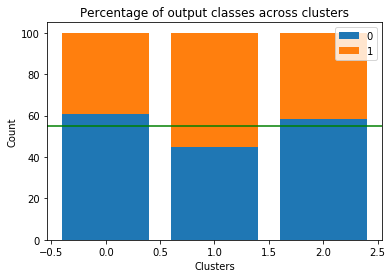

In [68]:
kmeans_function(X_rp1,2,10)
cluster_plots(KMeans(n_clusters=3,random_state=0).fit_predict(X_rp1),y_data1,55)

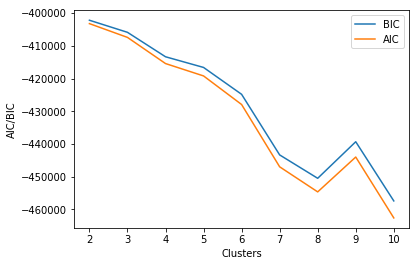

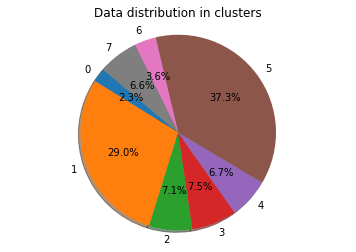

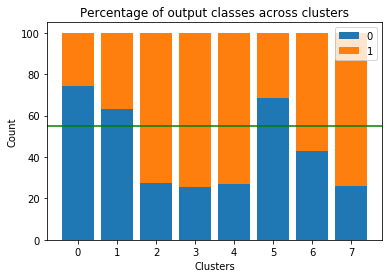

In [48]:
exp_max(X_dt1,2,10)
cluster_plots(GaussianMixture(8,covariance_type='full',random_state=0).fit(X_dt1).predict(X_dt1),y_data1,55)

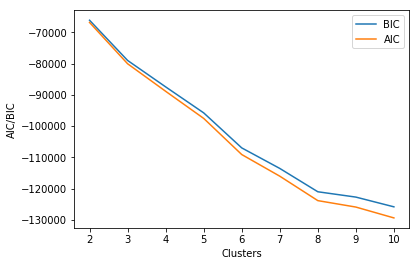

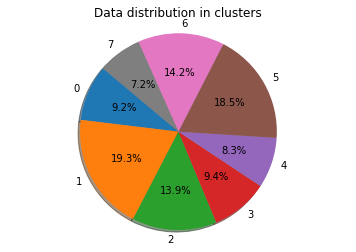

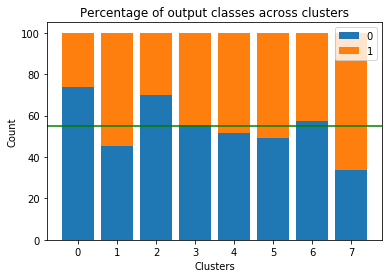

In [49]:
exp_max(X_pca1,2,10)
cluster_plots(GaussianMixture(8,covariance_type='full',random_state=0).fit(X_pca1).predict(X_pca1),y_data1,55)

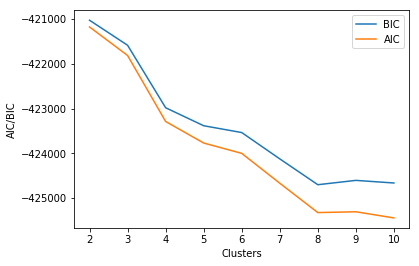

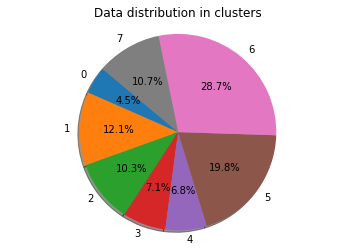

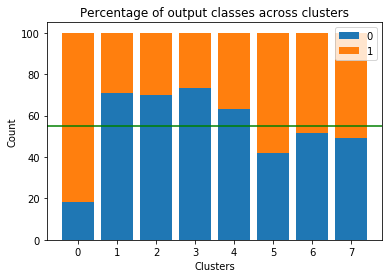

In [50]:
exp_max(X_ica1,2,10)
cluster_plots(GaussianMixture(8,covariance_type='full',random_state=0).fit(X_ica1).predict(X_ica1),y_data1,55)

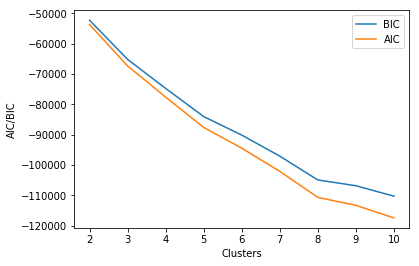

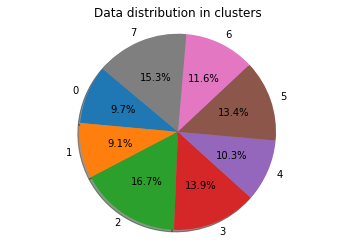

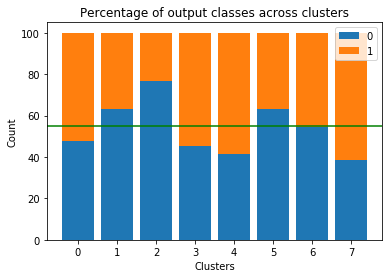

In [69]:
exp_max(X_rp1,2,10)
cluster_plots(GaussianMixture(8,covariance_type='full',random_state=0).fit(X_rp1).predict(X_rp1),y_data1,55)

##### Task 4 - Reduced Features as Neural Nets input

In [106]:
X_train1    , y_train1    , X_test1    , y_test1     = split(X_data1,y_data1)
X_train1_dt , y_train1_dt , X_test1_dt , y_test1_dt  = split(X_dt1  ,y_data1)
X_train1_pca, y_train1_pca, X_test1_pca, y_test1_pca = split(X_pca1 ,y_data1)
X_train1_ica, y_train1_ica, X_test1_ica, y_test1_ica = split(X_ica1 ,y_data1)
X_train1_rp , y_train1_rp , X_test1_rp , y_test1_rp  = split(X_rp1  ,y_data1)

param_1 = {'batch_size':[256],'epochs':[20],'optimizer':['sgd'],'first_hidden_units':[10],'second_hidden_units':[10],
           'hidden_activation_fun':['tanh'],'output_activation_func':['sigmoid']}

grid1_org,time1_org,acc1_org,train_acc1_org,test_acc1_org = ann(X_train1,y_train1,X_test1,y_test1,
                                                                X_train1.shape[1],1,param_1,3)
grid1_dt, time1_dt, acc1_dt, train_acc1_dt ,test_acc1_dt  = ann(X_train1_dt,y_train1_dt,X_test1_dt,y_test1_dt,
                                                                X_train1_dt.shape[1],1,param_1,3)
grid1_pca,time1_pca,acc1_pca,train_acc1_pca,test_acc1_pca = ann(X_train1_pca,y_train1_pca,X_test1_pca,y_test1_pca,
                                                                X_train1_pca.shape[1],1,param_1,3)
grid1_ica,time1_ica,acc1_ica,train_acc1_ica,test_acc1_ica = ann(X_train1_ica,y_train1_ica,X_test1_ica,y_test1_ica,
                                                                X_train1_ica.shape[1],1,param_1,3)
grid1_rp, time1_rp, acc1_rp, train_acc1_rp ,test_acc1_rp  = ann(X_train1_rp,y_train1_rp,X_test1_rp,y_test1_rp,
                                                                X_train1_rp.shape[1],1,param_1,3)
print(param_1)

{'batch_size': [256], 'epochs': [20], 'optimizer': ['sgd'], 'first_hidden_units': [10], 'second_hidden_units': [10], 'hidden_activation_fun': ['tanh'], 'output_activation_func': ['sigmoid']}


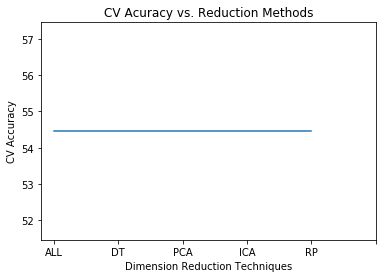

In [92]:
dim1 = np.array(['ALL','DT','PCA','ICA','RP'])
acc1 = np.array([acc1_org,acc1_dt,acc1_pca,acc1_ica,acc1_rp])
plt.plot(acc1)
plt.xticks([0,1,2,3,4,5],dim1)
plt.xlabel('Dimension Reduction Techniques')
plt.ylabel('CV Accuracy')
plt.title('CV Acuracy vs. Reduction Methods')
plt.show()

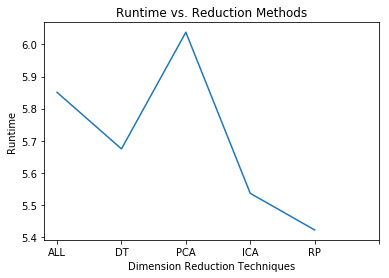

In [93]:
dim1 = np.array(['ALL','DT','PCA','ICA','RP'])
time1 = np.array([time1_org,time1_dt,time1_pca,time1_ica,time1_rp])
plt.plot(time1)
plt.xticks([0,1,2,3,4,5],dim1)
plt.xlabel('Dimension Reduction Techniques')
plt.ylabel('Runtime')
plt.title('Runtime vs. Reduction Methods')
plt.show()

##### Task 5 - Cluster Results as Neural Nets input

In [98]:
kms = KMeans(n_clusters=4,random_state=0).fit_predict(X_data1)
gmm = GaussianMixture(8,covariance_type='full',random_state=0).fit(X_data1).predict_proba(X_data1)
cluster1 = pd.DataFrame(gmm)
cluster1['kms'] = pd.DataFrame(kms)
X_train_c1,y_train_c1,X_test_c1,y_test_c1 = split(cluster1,y_data1)
grid1_k,time1_k,acc1_k,train_acc1_k,test_acc1_k=ann(X_train_c1,y_train_c1,X_test_c1,y_test_c1,X_train_c1.shape[1],1,param_1,3)

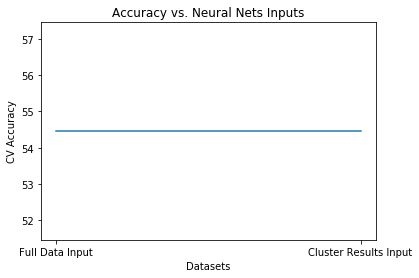

In [99]:
dim = np.array(['Full Data Input','Cluster Results Input'])
acc10 = np.array([acc1_org,acc1_k])
plt.plot(acc10)
plt.xticks([0,1],dim)
plt.xlabel('Datasets')
plt.ylabel('CV Accuracy')
plt.title('Accuracy vs. Neural Nets Inputs')
plt.show()

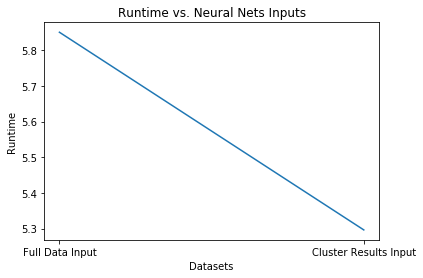

In [100]:
dim = np.array(['Full Data Input','Cluster Results Input'])
time10 = np.array([time1_org,time1_k])
plt.plot(time10)
plt.xticks([0,1],dim)
plt.xlabel('Datasets')
plt.ylabel('Runtime')
plt.title('Runtime vs. Neural Nets Inputs')
plt.show()

### Dataset 2 - Online Shoppers Purchasing Intention

##### Task 0 - Data Preprocessing

Response classes in dataset2
 0    10422
1     1908
Name: Revenue, dtype: int64


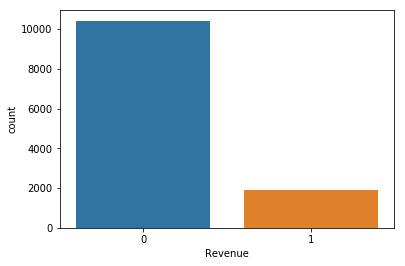

In [70]:
# ignoring warnings
warnings.filterwarnings('ignore')

# importing dataset
data2 = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv')
for i in range (10,16):
    dummy = pd.get_dummies(data2[data2.columns[i]],prefix=data2.columns[i])
    data2 = pd.concat([data2,dummy],axis=1)
cols2 = data2.columns
data2 = pd.concat([data2[list(cols2[:10])],data2.Weekend.astype(int),data2[list(cols2[18:])],data2.Revenue.astype(int)],axis=1)
data2 = data2.rename(columns={'VisitorType_New_Visitor':'VisitorType_New','VisitorType_Returning_Visitor':'VisitorType_Return'})

# normalizing the dataset
X_data2,y_data2 = data2.iloc[:,:-1],data2.iloc[:,-1]
X_data2 = (X_data2-X_data2.min())/(X_data2.max()-X_data2.min())
data2 = pd.concat([X_data2,y_data2],axis=1)

# frequency of response classes
print('Response classes in dataset2\n',y_data2.value_counts())
sns.countplot(data2.Revenue)
plt.show()

##### Task 1 - Clustering Algorithms

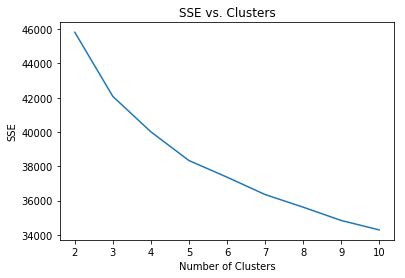

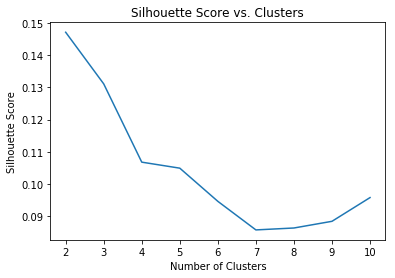

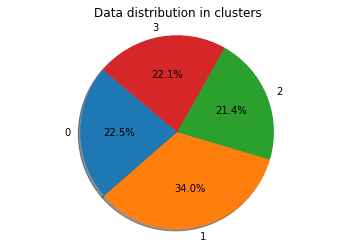

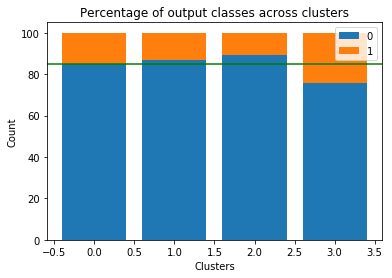

In [52]:
# K-Means
kmeans_function(X_data2,2,10)
cluster_plots(KMeans(n_clusters=4,random_state=0).fit_predict(X_data2),y_data2,85)

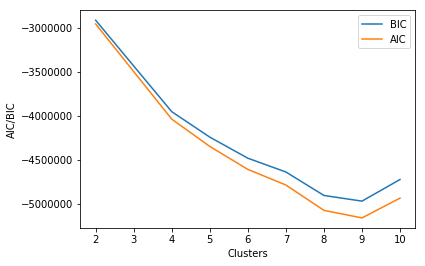

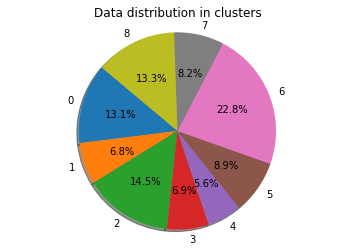

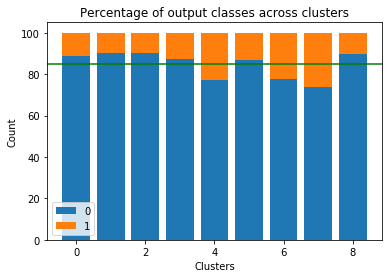

In [53]:
# Expectation Maximization
exp_max(X_data2,2,10)
cluster_plots(GaussianMixture(9,covariance_type='full',random_state=0).fit(X_data2).predict(X_data2),y_data2,85)

##### Task 2 - Dimensionality Reduction

Number of features before transformation: (12330, 74)
Number of features after transformation: (12330, 11)
Columns retained: Index(['Administrative', 'Administrative_Duration', 'Informational_Duration',
       'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates',
       'PageValues', 'Month_Mar', 'Month_May', 'Month_Nov'],
      dtype='object')


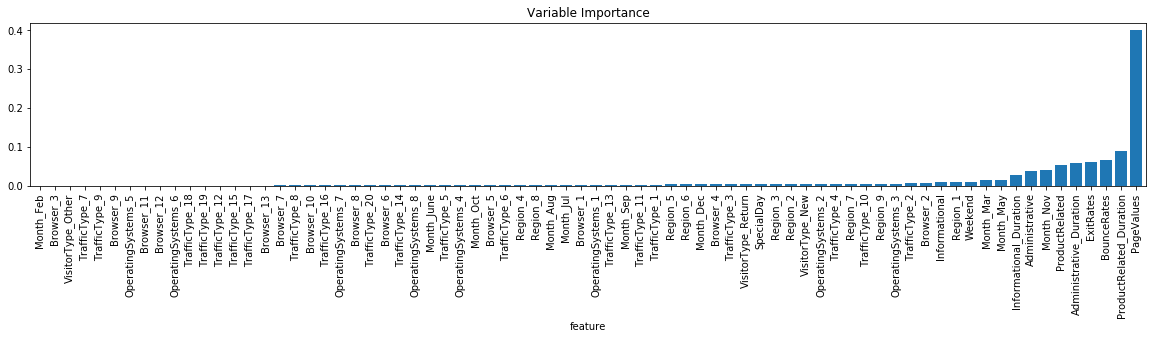

In [54]:
# DT
X_dt2 = features_dt(X_data2,y_data2)

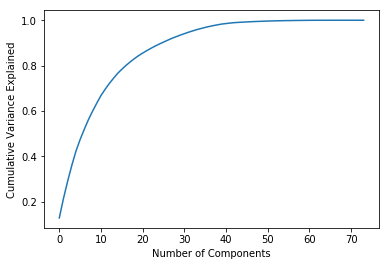

Number of features with no reduction: (12330, 74)
Number of features after PCA:
 (12330, 26)


In [55]:
# PCA
X_pca2 = features_pca(X_data2)

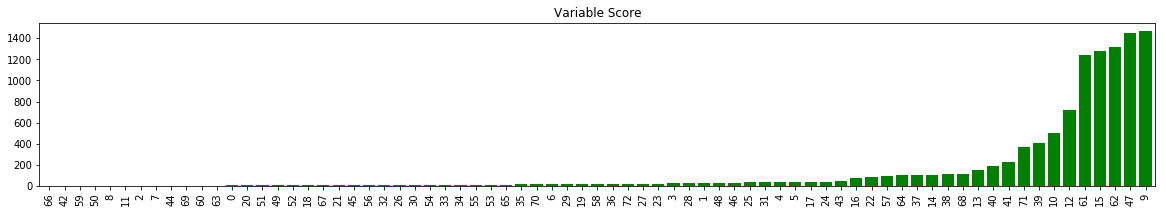

Number of features after ICA (12330, 6)


In [56]:
# ICA
ica = FastICA(random_state=0)
X_ica2 = ica.fit_transform(X_data2)
k,index=[],[]
for i in range(1,X_ica2.shape[1]):
    k.append(abs(kurtosis(X_ica2[:,i],fisher=True)))
    index.append(i)
kdata=pd.DataFrame(k,index)
kdata.reset_index(inplace=True)
kdata.columns=['index','kurtosis']
kdata=kdata.sort_values(['kurtosis'],ascending=[1])
plt.figure(figsize=(20, 3))
kdata['kurtosis'].plot.bar(width=0.8,color='green')
plt.title('Variable Score')
plt.show()
X_ica2=X_ica2[:,kdata[kdata['kurtosis']<=1]['index']]
print('Number of features after ICA',X_ica2.shape)

In [57]:
# RP
X_rp2 = features_rp(X_data2)

Number of components after reduction: (12330, 37)


##### Task 3 - Clustering + Reduction

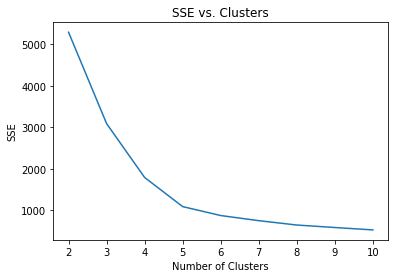

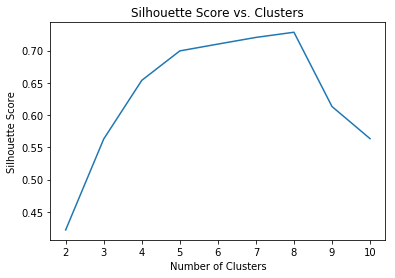

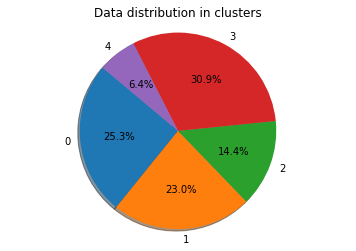

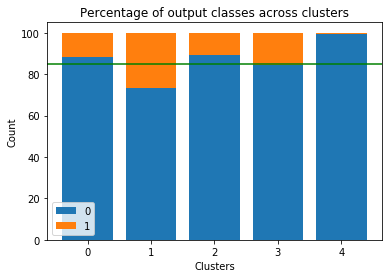

In [58]:
kmeans_function(X_dt2,2,10)
cluster_plots(KMeans(n_clusters=5,random_state=0).fit_predict(X_dt2),y_data2,85)

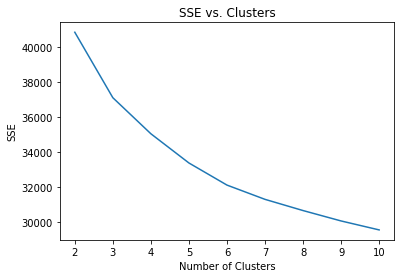

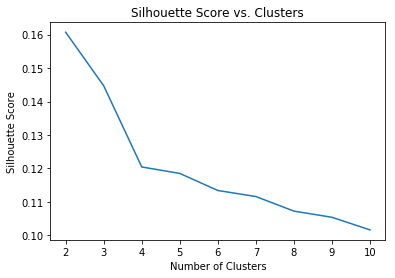

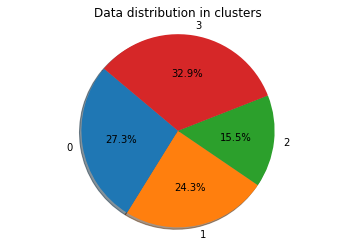

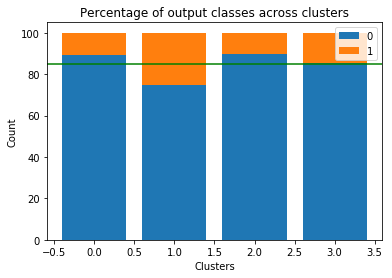

In [59]:
kmeans_function(X_pca2,2,10)
cluster_plots(KMeans(n_clusters=4,random_state=0).fit_predict(X_dt2),y_data2,85)

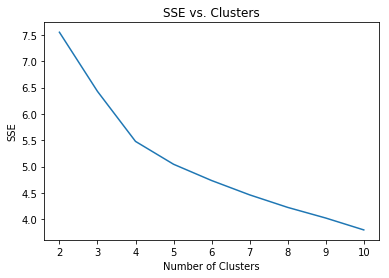

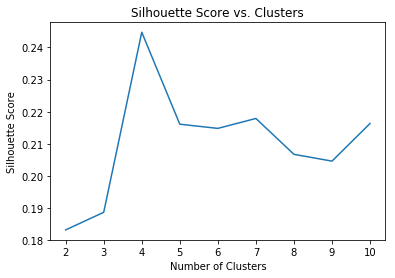

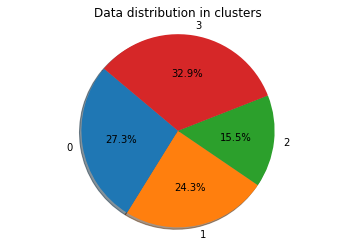

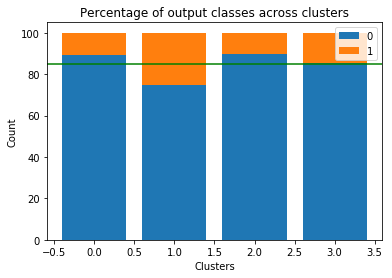

In [60]:
kmeans_function(X_ica2,2,10)
cluster_plots(KMeans(n_clusters=4,random_state=0).fit_predict(X_dt2),y_data2,85)

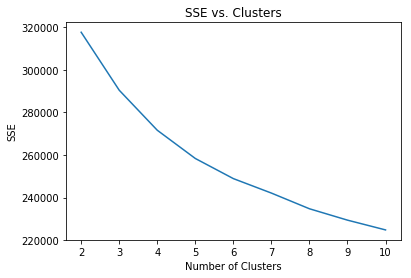

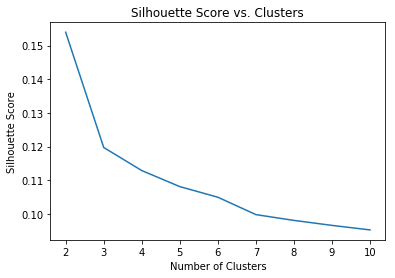

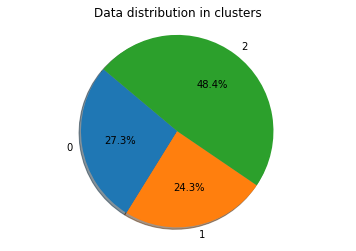

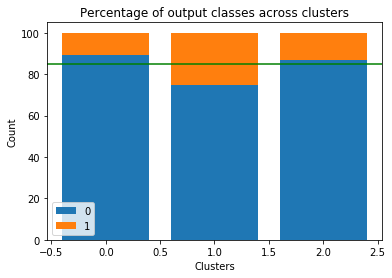

In [61]:
kmeans_function(X_rp2,2,10)
cluster_plots(KMeans(n_clusters=3,random_state=0).fit_predict(X_dt2),y_data2,85)

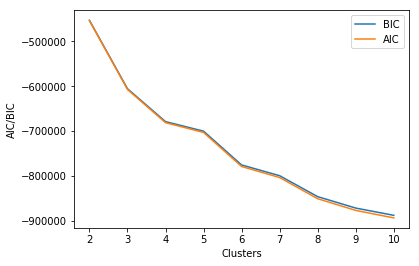

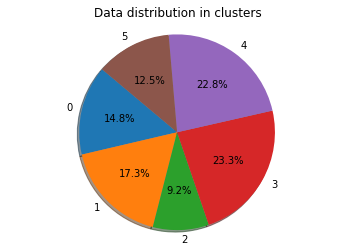

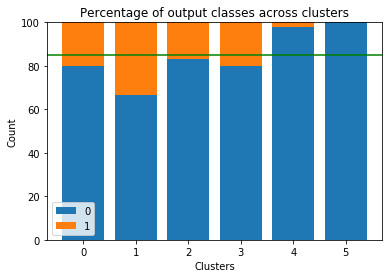

In [62]:
exp_max(X_dt2,2,10)
cluster_plots(GaussianMixture(6,covariance_type='full',random_state=0).fit(X_dt2).predict(X_dt2),y_data2,85)

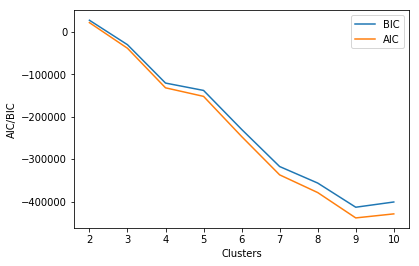

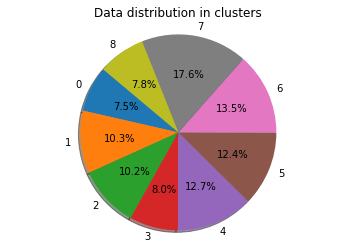

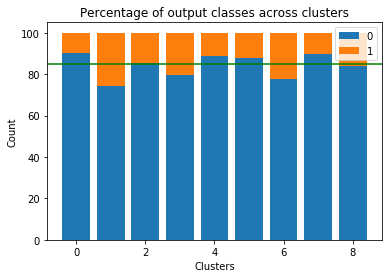

In [63]:
exp_max(X_pca2,2,10)
cluster_plots(GaussianMixture(9,covariance_type='full',random_state=0).fit(X_pca2).predict(X_pca2),y_data2,85)

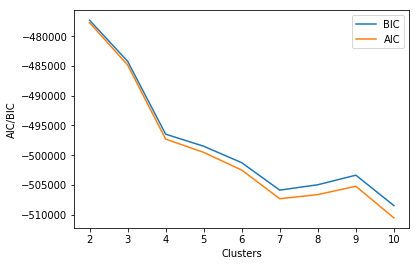

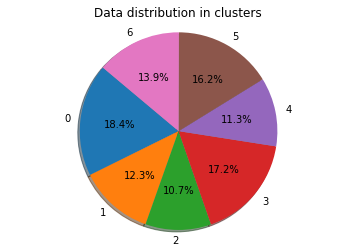

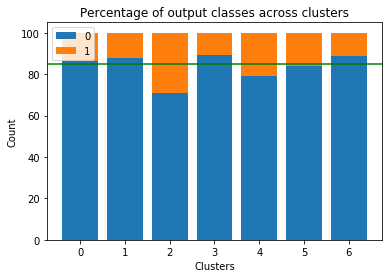

In [64]:
exp_max(X_ica2,2,10)
cluster_plots(GaussianMixture(7,covariance_type='full',random_state=0).fit(X_ica2).predict(X_ica2),y_data2,85)

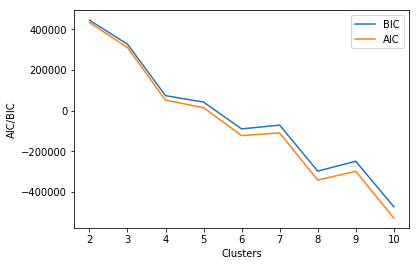

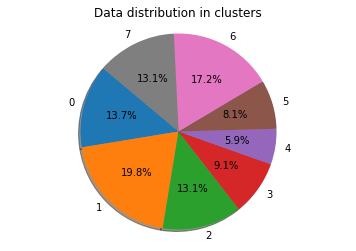

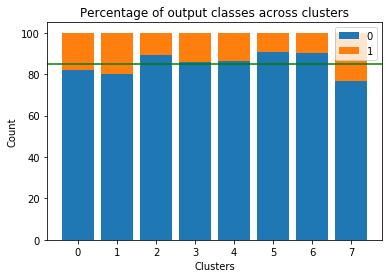

In [65]:
exp_max(X_rp2,2,10)
cluster_plots(GaussianMixture(8,covariance_type='full',random_state=0).fit(X_rp2).predict(X_rp2),y_data2,85)

##### Task 4 - Reduced Features as Neural Nets input

In [104]:
X_train2    , y_train2    , X_test2    , y_test2     = split(X_data2,y_data2)
X_train2_dt , y_train2_dt , X_test2_dt , y_test2_dt  = split(X_dt2  ,y_data2)
X_train2_pca, y_train2_pca, X_test2_pca, y_test2_pca = split(X_pca2 ,y_data2)
X_train2_ica, y_train2_ica, X_test2_ica, y_test2_ica = split(X_ica2 ,y_data2)
X_train2_rp , y_train2_rp , X_test2_rp , y_test2_rp  = split(X_rp2  ,y_data2)

param_2 = {'batch_size':[256],'epochs':[20],'optimizer':['sgd'],
           'first_hidden_units':[10],'second_hidden_units':[10],
           'hidden_activation_fun':['sigmoid'],'output_activation_func':['sigmoid']}

grid2_org,time2_org,acc2_org,train_acc2_org,test_acc2_org = ann(X_train2,y_train2,X_test2,y_test2,
                                                                X_train2.shape[1],1,param_2,3)
grid2_dt, time2_dt, acc2_dt, train_acc2_dt ,test_acc2_dt  = ann(X_train2_dt,y_train2_dt,X_test2_dt,y_test2_dt,
                                                                X_train2_dt.shape[1],1,param_2,3)
grid2_pca,time2_pca,acc2_pca,train_acc2_pca,test_acc2_pca = ann(X_train2_pca,y_train2_pca,X_test2_pca,y_test2_pca,
                                                                X_train2_pca.shape[1],1,param_2,3)
grid2_ica,time2_ica,acc2_ica,train_acc2_ica,test_acc2_ica = ann(X_train2_ica,y_train2_ica,X_test2_ica,y_test2_ica,
                                                                X_train2_ica.shape[1],1,param_2,3)
grid2_rp, time2_rp, acc2_rp, train_acc2_rp ,test_acc2_rp  = ann(X_train2_rp,y_train2_rp,X_test2_rp,y_test2_rp,
                                                                X_train2_rp.shape[1],1,param_2,3)
print(param_2)

{'batch_size': [256], 'epochs': [20], 'optimizer': ['sgd'], 'first_hidden_units': [10], 'second_hidden_units': [10], 'hidden_activation_fun': ['sigmoid'], 'output_activation_func': ['sigmoid']}


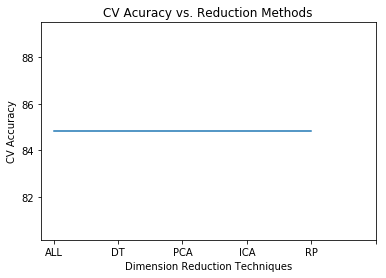

In [89]:
dim2 = np.array(['ALL','DT','PCA','ICA','RP'])
acc2 = np.array([acc2_org,acc2_dt,acc2_pca,acc2_ica,acc2_rp])
plt.plot(acc2)
plt.xticks([0,1,2,3,4,5],dim2)
plt.xlabel('Dimension Reduction Techniques')
plt.ylabel('CV Accuracy')
plt.title('CV Acuracy vs. Reduction Methods')
plt.show()

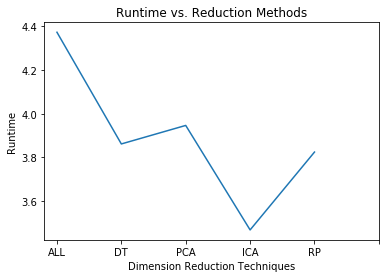

In [90]:
dim2 = np.array(['ALL','DT','PCA','ICA','RP'])
time2 = np.array([times2_org,times2_dt,times2_pca,times2_ica,times2_rp])
plt.plot(time2)
plt.xticks([0,1,2,3,4,5],dim2)
plt.xlabel('Dimension Reduction Techniques')
plt.ylabel('Runtime')
plt.title('Runtime vs. Reduction Methods')
plt.show()

##### Task 5 - Cluster Results as Neural Nets input

In [101]:
kms = KMeans(n_clusters=4,random_state=0).fit_predict(X_data2)
gmm = GaussianMixture(8,covariance_type='full',random_state=0).fit(X_data2).predict_proba(X_data2)
cluster2 = pd.DataFrame(gmm)
cluster2['kms'] = pd.DataFrame(kms)
X_train_c2,y_train_c2,X_test_c2,y_test_c2 = split(cluster2,y_data2)
grid2_k,time2_k,acc2_k,train_acc2_k,test_acc2_k=ann(X_train_c2,y_train_c2,X_test_c2,y_test_c2,X_train_c2.shape[1],1,param_2,3)

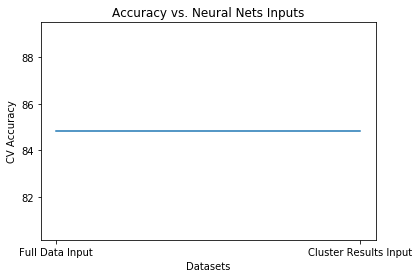

In [102]:
dim = np.array(['Full Data Input','Cluster Results Input'])
acc20 = np.array([acc2_org,acc2_k])
plt.plot(acc20)
plt.xticks([0,1],dim)
plt.xlabel('Datasets')
plt.ylabel('CV Accuracy')
plt.title('Accuracy vs. Neural Nets Inputs')
plt.show()

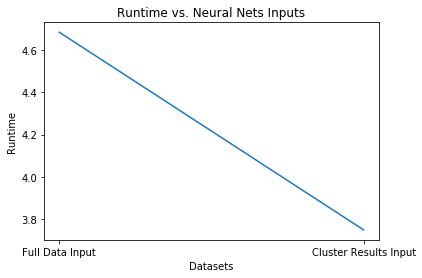

In [103]:
dim = np.array(['Full Data Input','Cluster Results Input'])
time20 = np.array([time2_org,time2_k])
plt.plot(time20)
plt.xticks([0,1],dim)
plt.xlabel('Datasets')
plt.ylabel('Runtime')
plt.title('Runtime vs. Neural Nets Inputs')
plt.show()